<a href="https://colab.research.google.com/github/nmningmei/LevelUpPythonTutorial/blob/master/1_15_joblib_the_for_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This tutorial is **NOT** telling you to parallelize all your for-loops, and that is impossible, but this tutorial is to show you have to parallelize your simple processes in a for-loop to speed up things, such as the resamplings in the bootstrapping statistics.

In [73]:
import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib import pyplot as plt

In [74]:
n_permutations = int(1e4)

# Let's create 2 samples for a comparison test.

In [75]:
p = 1.0
iterator = tqdm(range(int(1e5)))
for _ in iterator:
    a = np.random.normal(loc = 0.0, scale = 1.0, size = 25)
    b = np.random.normal(loc = 0.1, scale = 1.1, size = 20)
    t,p = stats.ttest_ind(a,b,equal_var = False)
    iterator.set_description(f't(44) = {t:.4f},p = {p:.4f}')
    if 0.04 <= p <= 0.05:
        break

t(44) = -2.0715,p = 0.0445:   0%|          | 41/100000 [00:00<04:22, 381.37it/s]


# Let's visualize the data

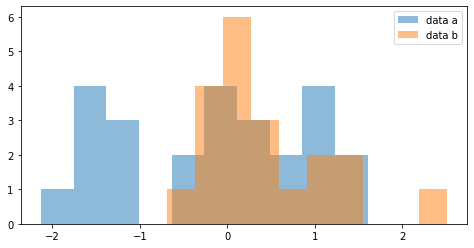

In [76]:
fig,ax = plt.subplots(figsize = (8,4))
ax.hist(a,label = 'data a',alpha = .5)
ax.hist(b,label = 'data b',alpha = .5)
ax.legend(loc = 'best')

# First we estimate the mean and standard deviation of the samples using resampling method

In [77]:
%%timeit
iterator = tqdm(range(n_permutations))
mean_a,std_a = [],[]
for _ in iterator:
    a_sampled = np.random.choice(a,size = a.shape[0],replace = True)
    mean_a.append(a_sampled.mean())
    std_a.append(a_sampled.std())
mean_a = np.array(mean_a)
std_a = np.array(std_a)

100%|██████████| 10000/10000 [00:00<00:00, 11671.05it/s]

1 loop, best of 5: 664 ms per loop


In [78]:
iterator = tqdm(range(n_permutations))
mean_a,std_a = [],[]
for _ in iterator:
    a_sampled = np.random.choice(a,size = a.shape[0],replace = True)
    mean_a.append(a_sampled.mean())
    std_a.append(a_sampled.std())
mean_a = np.array(mean_a)
std_a = np.array(std_a)

100%|██████████| 10000/10000 [00:00<00:00, 13337.70it/s]


In [79]:
print(f'Direct method: mean = {a.mean():.4f}, std = {a.std():.4f}\nResampling method: mean = {mean_a.mean():.4f}, se = {std_a.mean():.4f}')

Direct method: mean = -0.1146, std = 1.0733
Resampling method: mean = -0.1133, se = 1.0472


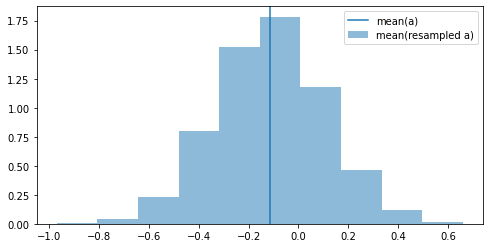

In [80]:
fig,ax = plt.subplots(figsize = (8,4))
ax.axvline(a.mean(),label = 'mean(a)')
ax.hist(mean_a,label = 'mean(resampled a)',alpha = .5,density = True)
ax.legend()

# We can try to speed up the resampling since the samples are independent and sampled with replacement

In [81]:
%%timeit
a_resampled = np.random.choice(a,size = (n_permutations,a.shape[0]),replace = True)
mean_a = a_resampled.mean(1)
std_a = a_resampled.std(1)

100 loops, best of 5: 5.43 ms per loop


# Compared to about 873 ms per loop above, we speed up by 155 times.

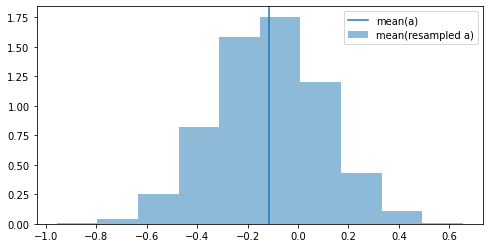

In [82]:
a_resampled = np.random.choice(a,size = (n_permutations,a.shape[0]),replace = True)
mean_a = a_resampled.mean(1)
fig,ax = plt.subplots(figsize = (8,4))
ax.axvline(a.mean(),label = 'mean(a)')
ax.hist(mean_a,label = 'mean(resampled a)',alpha = .5,density = True)
ax.legend()

In [83]:
print(f'Direct method: mean = {a.mean():.4f}, std = {a.std():.4f}\nResampling method: mean = {mean_a.mean():.4f}, se = {std_a.mean():.4f}')

Direct method: mean = -0.1146, std = 1.0733
Resampling method: mean = -0.1166, se = 1.0472


# The basic idea of bootstrapping comparison is to (in this case, we are doing unmatched sample comparison):

$$H_0: \bar{x} = \bar{y}$$
$$H_a: \bar{x} \neq \bar{y}$$

1. compare the original data, and store the difference (experiment difference)
2. concatenate the data, and then split them into two new groups
3. compare the two new groups, and store the diffrence (empirical chances)
4. repeat step 2 and 4 for a large amount of times to estimate the distribution of the empirical chance level
5. the probability of $H_0$ being true is the proportion of the empirical chance estimates being greater or less than the experiment difference (two-tailed)

In [84]:
%%timeit
iterator = tqdm(range(n_permutations))
diff = a.mean() - b.mean()
concatenated_a_b = np.concatenate([a,b])
new_diffs = np.zeros((n_permutations,))
for ii in iterator:
    new_groups = np.random.choice(concatenated_a_b,size = a.shape[0] + b.shape[0],replace = False)
    new_a = new_groups[:a.shape[0]]
    new_b = new_groups[a.shape[0]:]
    new_diffs[ii] = new_a.mean() - new_b.mean()


100%|██████████| 10000/10000 [00:00<00:00, 14767.26it/s]

1 loop, best of 5: 555 ms per loop


In [85]:
iterator = tqdm(range(n_permutations))
diff = a.mean() - b.mean()
concatenated_a_b = np.concatenate([a,b])
new_diffs = np.zeros((n_permutations,))
for ii in iterator:
    new_groups = np.random.choice(concatenated_a_b,size = a.shape[0] + b.shape[0],replace = False)
    new_a = new_groups[:a.shape[0]]
    new_b = new_groups[a.shape[0]:]
    new_diffs[ii] = new_a.mean() - new_b.mean()


100%|██████████| 10000/10000 [00:00<00:00, 24624.78it/s]


In [86]:
# here we add 1 to both the numerator and the denominator to avoid zeros
pval = (np.sum(np.abs(new_diffs) >= np.abs(diff)) + 1) / (n_permutations + 1)
print(f'p value = {pval:.4f}')

p value = 0.0537


# Because we created a "boarder line significant" dataset, the bootstrapping method shows that it is not statistically significant at the 0.05 level.

# Let's speed up this using Joblib

In [87]:
from joblib import Parallel,delayed

## We need to make a function for the processes in the for-loop, like what is computed in one cycle

In [88]:
def _process(concatenated_a_b):
    new_groups = np.random.choice(concatenated_a_b,size = a.shape[0] + b.shape[0],replace = False)
    new_a = new_groups[:a.shape[0]]
    new_b = new_groups[a.shape[0]:]
    return new_a.mean() - new_b.mean()

In [89]:
%%timeit
new_diffs_parallelized = Parallel(n_jobs = -1, verbose = 1)(delayed(_process)(**{'concatenated_a_b':concatenated_a_b}) for _ in range(n_permutations))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2054 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 7434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 7434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 7434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 7434 tasks      | elapsed:    0.7s
[Para

1 loop, best of 5: 791 ms per loop


[Parallel(n_jobs=-1)]: Done 7434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    0.8s finished


## Compared to what we had 555 ms, we speed up for 100 times

## Let's break down what `parallel` and `delayed` did to parallelize the function `_process()`

`new_diffs_parallelized = Parallel(n_jobs = -1, verbose = 1)(delayed(_process)(**{'concatenated_a_b':concatenated_a_b}) for _ in range(n_permutations))` is composed by two parts: `parallel()` and `(delayed()() for _ in range())`

`(delayed()() for _ in range())` can be seen as the argument calling of the `parallel()` function

Like:

`f = parallel()`

and

we call the function `f` by `f(something)`, and the "something" is `delayed()() for _ in range()`

The same logic goes for `delayed()`, which explains why there are two `()`s after `delayed`.

We just need to specify the arguments of the `_process()` function in a dictionary (and use `**` to expand them) or in a list (and use `*` to expand them), (please see xargs for python functions).